In [44]:
import requests as re
from bs4 import BeautifulSoup
from csv import writer
from datetime import date, timedelta
import pandas as pd
import numpy as np
import warnings
# for latex equations
from IPython.display import Math, Latex
# for displaying images
from IPython.core.display import Image
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import mplcursors

import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(5,5)})


InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

pd.set_option('display.width', 1000000)
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)


fund_id_map = {
    'MIRAE': 45,
    'PPFAS': 64,
    'QUANT': 13,
    'MOTI': 55,
    'UTI': 28,
    'NIPPON': 21,
    'HDFC': 9
} 

fund_scheme_map = {    
   'MIRAE': {
        'mirae_tax_saver': 135781
    },
    'PPFAS': {
        'ppfas_flexi_cap': 122639
    },
    'QUANT': {
        'quant_active_fund': 120823,
        'quant_dynamic_asset': 151713
    },
    'MOTI': {
        'moti_nifty_200_momentum': 149800
     },
    'UTI': {
        'uti_midcap_quality_50': 150313
    },
    'NIPPON': {
        'nippon_alpha_low_volatility': 150487,
    },
    'HDFC': {
        'nifty_50_index': 119063
    }
}



In [45]:

st_dt = date(2023, 8, 1)
en_dt = st_dt.replace(year=st_dt.year +4)



def fetch_and_write():
    for fund, mfID in fund_id_map.items():
        for scheme ,scID in fund_scheme_map[fund].items():
            
            start_dt = st_dt
            end_dt = en_dt
            
            while start_dt < date.today():
                resp = fetch(mfID, scID, start_dt, end_dt)            
                soup = BeautifulSoup(resp.content)            
                
                start_dt = end_dt + timedelta(days =1)
                end_dt = end_dt.replace(year = end_dt.year +4)
                
                
                for child in soup.find_all('tbody')[0].find_all('tr'):
                    td_list = child.find_all('td')

                    if(len(td_list) !=4 ):
                       continue

                    x = [td_list[3].string, td_list[0].string]
                    with open("{}.csv".format(scheme), 'a') as f_object:
                        writer_object = writer(f_object)
                        writer_object.writerow(x)
                        f_object.close()                                                
                
            
def fetch(mfID, scID, sDate, eDate):
    url = 'https://www.amfiindia.com/modules/NavHistoryPeriod'    
    
    data = {
      'mfID': mfID,
      'scID': scID,
      'fDate': sDate.strftime('%d-%b-%Y'),
      'tDate': eDate.strftime('%d-%b-%Y'),
    }

    return re.post(url = url, data =data)
    

fetch_and_write()


In [52]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

out = pd.DataFrame(columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']);

final_df = pd.DataFrame()


for fund, mfID in fund_id_map.items():
    for scheme ,scID in fund_scheme_map[fund].items():        
        column_mapping = {
            'nav': scheme
        }
        df = pd.read_csv('{}.csv'.format(scheme), names= ['date', 'nav'], parse_dates=['date'], index_col = ['date'], skiprows=57)
        df.rename(columns=column_mapping, inplace=True)
        final_df = pd.concat([final_df, df], axis=1)
        
        
#         out.loc[scheme] = df['1yr_roll_ret'].iloc[245:].describe().values

final_df = final_df.iloc[1:,:]

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Normalized NAV')

Text(0.5, 1.0, 'Comparative Performance of Funds')

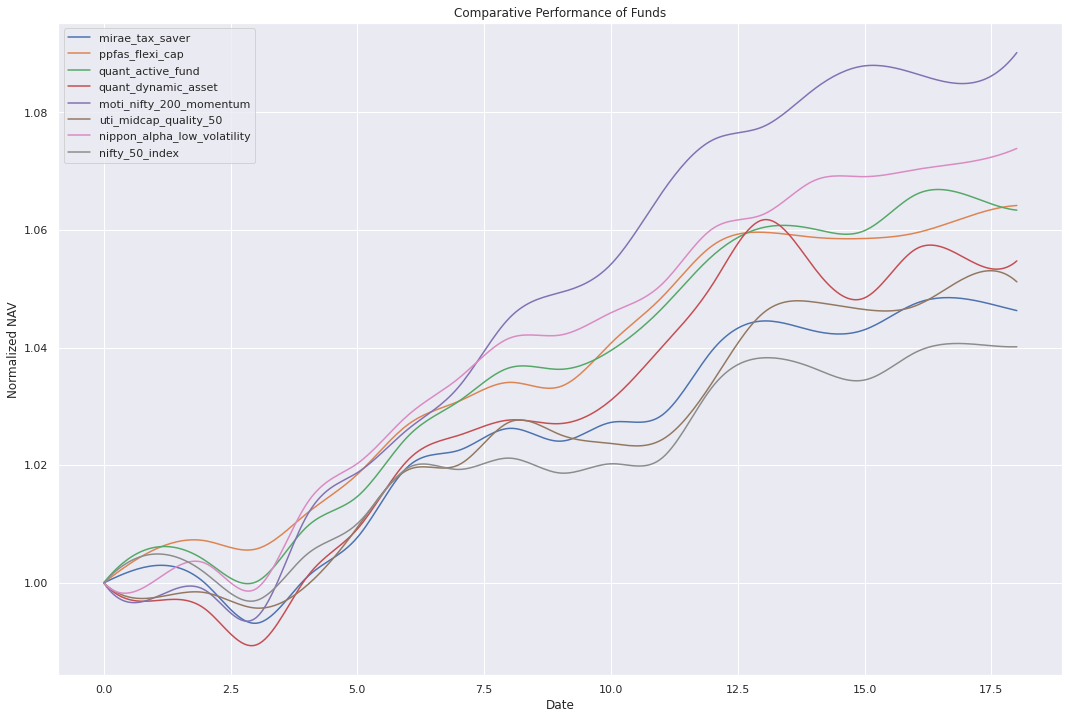

In [53]:
pd.options.display.max_rows = 25000
from scipy.interpolate import make_interp_spline


df_normalized = final_df / final_df.iloc[0]

# Plot the normalized data
# plt.figure(figsize=(20, 12))
# df_normalized.reset_index();

x_values = df_normalized.index.to_numpy()

fig, ax = plt.subplots(figsize=(18, 12))


for fund in df_normalized.columns.values:
    spline = make_interp_spline(range(len(x_values)), df_normalized[fund].values, k=3)
    x_smooth = np.linspace(0, len(x_values) - 1, 300)
    y_smooth = spline(x_smooth)

    ax.plot(x_smooth, y_smooth, label=fund)

#     ax.plot(x_values, df_normalized[fund].values, label=fund)

    
ax.set_xlabel('Date')
ax.set_ylabel('Normalized NAV')
ax.set_title('Comparative Performance of Funds')

# Add legend
ax.legend()
df = df_normalized
# Annotate the plot with data labels on cursor hover
def hover(event):
    visibility_changed = False
    for i, x in enumerate(x_values):
        for col in df.columns:
            y = df.loc[df.index[i], col]
            contains, _ = ax.lines[df.columns.get_loc(col)].contains(event)
            if contains:
                visibility_changed = True
                ax.annotate(f"{df.index[i]}: {col} - {y}", xy=(x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    if visibility_changed:
        plt.draw()

# Connect the hover function to the mouse motion event
cid = fig.canvas.mpl_connect('motion_notify_event', hover)

# Display the plot
plt.show()

In [54]:
# Calculate daily returns
returns = final_df.pct_change()
# display(final_df)
# Assume a risk-free rate (e.g., 0.02 for 2%)
risk_free_rate = 0.00027

# Calculate the Sharpe ratio
sharpe_ratio = (returns.mean() - risk_free_rate) / returns.std()

type(sharpe_ratio)
# Display the Sharpe ratio
print("Sharpe Ratio:")
print(sharpe_ratio.sort_values(ascending=False))


#  Calculate the Sortino ratio
downside_returns = np.minimum(returns, 0)  # Consider only negative returns
downside_volatility = downside_returns.std()
sortino_ratio = (returns.mean() - risk_free_rate) / downside_volatility

# Display the Sortino ratio
print("\nSortino Ratio:")
print(sortino_ratio.sort_values(ascending=False))

pandas.core.series.Series

Sharpe Ratio:
ppfas_flexi_cap                0.963
nippon_alpha_low_volatility    0.878
moti_nifty_200_momentum        0.823
quant_active_fund              0.736
uti_midcap_quality_50          0.528
mirae_tax_saver                0.466
nifty_50_index                 0.423
quant_dynamic_asset            0.422
dtype: float64

Sortino Ratio:
ppfas_flexi_cap                8.169
moti_nifty_200_momentum        3.623
nippon_alpha_low_volatility    3.605
quant_active_fund              2.930
uti_midcap_quality_50          2.643
nifty_50_index                 1.380
mirae_tax_saver                1.284
quant_dynamic_asset            1.133
dtype: float64
